In [1]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
from sklearn.model_selection import KFold, cross_val_score
import joblib
from collections import defaultdict

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from IPython.display import Image

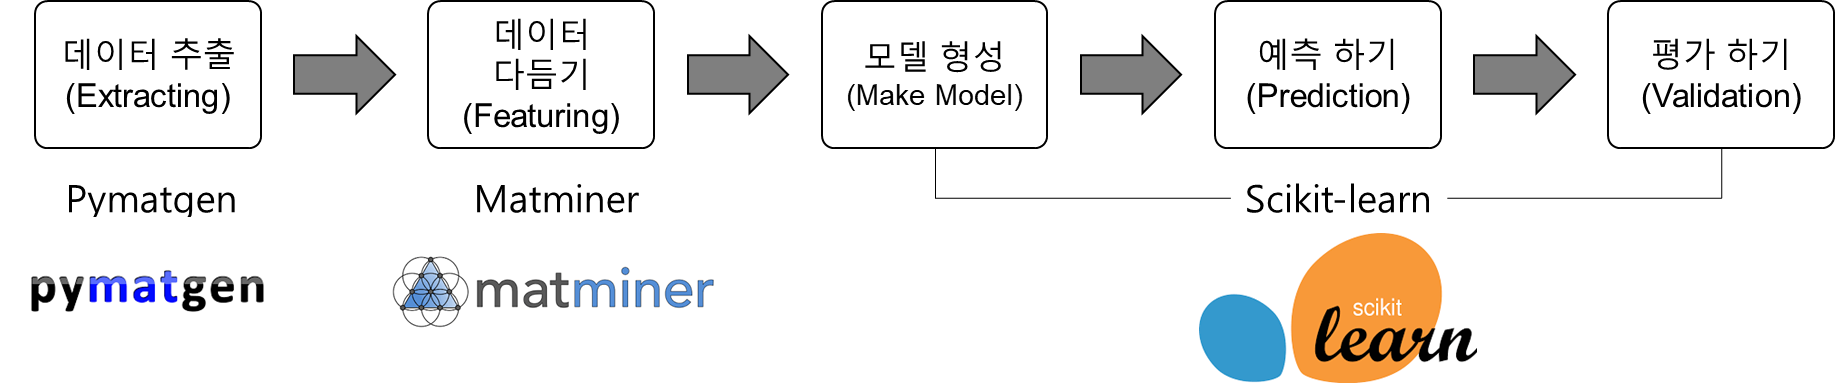

In [2]:
Image('image/matminer1.PNG')

# 3 ~ 4. 모델 형성 및 예측 하기 (Make Model & Prediction)
## 데이터 불러오기 (load data)

bulk modulus를 예측하는 모델을 sci-kit learn을 통해 만들것이다. 우선, 모델을 형성하기 위해서는 feature들과 target을 지정해야 한다. feature는 data.csv에서 K_VRH, log_KVRH를 제외할 것이다. 그리고, sci-kit learn에서는 string 형태는 예측할 수 없기 때문에 icsd_ids, pretty_formula, composition feature들을 제외할 것이다.<br> 

(In order to form a model, features and targets must be specified. The feature will exclude K_VRH and log_KVRH from data.csv. And, icsd_ids, pretty_formula, and composition features will be excluded because the string shape is unpredictable in sci-kit learn.)

In [3]:
df = pd.read_csv("data.csv",index_col=0)
df.dropna()
df[['pretty_formula','icsd_ids','composition']]

,pretty_formula,icsd_ids,composition
material_id,,,
mp-1002206,SiC,[182362],Si1 C1
mp-11279,TiBe,"[616457, 58743]",Ti1 Be1
mp-11714,SiC,[164971],Si1 C1
mp-1490,AlAu4,"[655053, 104616, 606018, 606030, 57498]",Al1 Au4
mp-1934,LiZn,"[642409, 642412, 104791, 104792]",Li1 Zn1
...,...,...,...
mp-41283,BaLaTaMnO6,[],Ba1 La1 Ta1 Mn1 O6
mp-556562,LiAsH6(OF2)3,[416608],Li1 As1 H6 O3 F6
mp-556856,BaCSNCl,[94400],Ba1 C1 S1 N1 Cl1


In [4]:
features = df.drop(['K_VRH','log_KVRH','pretty_formula','icsd_ids','composition'],axis=1)

log_target = df[['log_KVRH']]
target = df[['K_VRH']]

In [5]:
index = df.index.tolist()
np.random.shuffle(index)

ratio = int(0.7 * len(index))

train_x = features.iloc[:ratio]
train_log_y = log_target[:ratio]
train_y = target[:ratio]

test_x = features.iloc[ratio:]
test_log_y = log_target[ratio:]
test_y = target[ratio:]

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Load model Predict for Linear Regression
lr1 = LinearRegression()
log_lr_fit = lr1.fit(train_x,train_log_y)
lr2 = LinearRegression()
lr_fit = lr2.fit(train_x,train_y)

# Predict for andom Forest
rf1 = RandomForestRegressor()
log_rf_fit = rf1.fit(train_x,train_log_y)
rf2 = RandomForestRegressor()
rf_fit = rf2.fit(train_x,train_y)

# Predict for Gradient Boosting
gbr1 = GradientBoostingRegressor(n_estimators=100,max_depth=4)
log_gbr_fit = gbr1.fit(train_x,train_log_y)
gbr2 = GradientBoostingRegressor(n_estimators=100,max_depth=4)
gbr_fit2 = gbr2.fit(train_x,train_y)

C:\Users\sora_\AppData\Local\Temp\ipykernel_6280\4167010821.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  log_lr_fit = rf1.fit(train_x,train_log_y)
C:\Users\sora_\AppData\Local\Temp\ipykernel_6280\4167010821.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  lr_fit = rf2.fit(train_x,train_y)
D:\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = colum

In [47]:
# Predict for andom Forest
rf1 = RandomForestRegressor()
log_rf_fit = rf1.fit(train_x,train_log_y)
rf2 = RandomForestRegressor()
rf_fit = rf2.fit(train_x,train_y)

C:\Users\sora_\AppData\Local\Temp\ipykernel_6280\798195169.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  log_rf_fit = rf1.fit(train_x,train_log_y)
C:\Users\sora_\AppData\Local\Temp\ipykernel_6280\798195169.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_fit = rf2.fit(train_x,train_y)


## 교차 검증 (Cross Validation)

보통은 데이터를 train, test set으로 각각 구분하여 모델을 검증한다. 하지만, 고정된 test set을 통해 모델의 성능을 검증하고 수정하면 내가 만든 test set에만 모델이 된다. 즉, 과적합(overfitting)되어지는 것이다.

이를 해결하고자 교차 검증을 진행한다. 교차 검증은 밑에와 같은 이미지로 보여줄 수 있다.

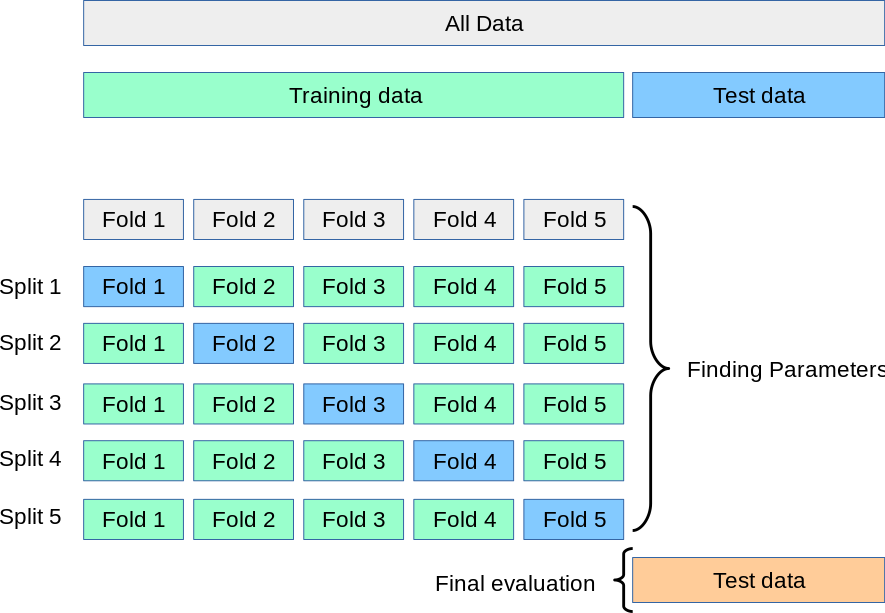

In [17]:
Image("image/machine1.png")

In [26]:
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)

data_dict = defaultdict(list)
r2_scores = cross_val_score(lr1, features, log_target, scoring='r2', cv=crossvalidation, n_jobs=-1)
print("Linear Regression (log(GPa))")
for e,i in enumerate(r2_scores) :
    if e == 0 :
        serial = '1st'
    elif e == 1 :
        serial = '2nd' 
    elif e == 2 :
        serial = '3rd'
    else :
        serial = "%i th"%(e+1)
    print("%s R2 score : %.3f" %(serial, i))
    data_dict['LR_log'].append(i)
print("Mean R2 score : %.3f\n"%(r2_scores.mean()))   

r2_scores = cross_val_score(lr2, features, target, scoring='r2', cv=crossvalidation, n_jobs=-1)
print("Linear Regression (GPa)")
for e,i in enumerate(r2_scores) :
    if e == 0 :
        serial = '1st'
    elif e == 1 :
        serial = '2nd' 
    elif e == 2 :
        serial = '3rd'
    else :
        serial = "%i th"%(e+1)
    print("%s R2 score : %.3f" %(serial, i))
    data_dict['LR'].append(i)
print("Mean R2 score : %.3f\n"%(r2_scores.mean()))   


r2_scores = cross_val_score(rf1, features, log_target, scoring='r2', cv=crossvalidation, n_jobs=-1)
print("Random Forest (log(GPa))")
for e,i in enumerate(r2_scores) :
    if e == 0 :
        serial = '1st'
    elif e == 1 :
        serial = '2nd' 
    elif e == 2 :
        serial = '3rd'
    else :
        serial = "%i th"%(e+1)
    print("%s R2 score : %.3f" %(serial, i))
    data_dict['RF_log'].append(i)
print("Mean R2 score : %.3f\n"%(r2_scores.mean()))     

r2_scores = cross_val_score(rf2, features, target, scoring='r2', cv=crossvalidation, n_jobs=-1)
print("Random Forest (GPa)")
for e,i in enumerate(r2_scores) :
    if e == 0 :
        serial = '1st'
    elif e == 1 :
        serial = '2nd' 
    elif e == 2 :
        serial = '3rd'
    else :
        serial = "%i th"%(e+1)
    print("%s R2 score : %.3f" %(serial, i))
    data_dict['RF'].append(i)
print("Mean R2 score : %.3f\n"%(r2_scores.mean()))   

r2_scores = cross_val_score(gbr1, features, log_target, scoring='r2', cv=crossvalidation, n_jobs=-1)
print("Gradient Boosting (log(GPa))")
for e,i in enumerate(r2_scores) :
    if e == 0 :
        serial = '1st'
    elif e == 1 :
        serial = '2nd' 
    elif e == 2 :
        serial = '3rd'
    else :
        serial = "%i th"%(e+1)
    print("%s R2 score : %.3f" %(serial, i))
    data_dict['GBR_log'].append(i)
print("Mean R2 score : %.3f\n"%(r2_scores.mean()))

r2_scores = cross_val_score(gbr2, features, target, scoring='r2', cv=crossvalidation, n_jobs=-1)
print("Gradient Boosting (GPa)")
for e,i in enumerate(r2_scores) :
    if e == 0 :
        serial = '1st'
    elif e == 1 :
        serial = '2nd' 
    elif e == 2 :
        serial = '3rd'
    else :
        serial = "%i th"%(e+1)
    print("%s R2 score : %.3f" %(serial, i))
    data_dict['GBR'].append(i)
print("Mean R2 score : %.3f\n"%(r2_scores.mean()))

Linear Regression (log(GPa))
1st R2 score : 0.810
2nd R2 score : 0.842
3rd R2 score : 0.790
4 th R2 score : 0.812
5 th R2 score : 0.792
6 th R2 score : 0.818
7 th R2 score : 0.825
8 th R2 score : 0.794
9 th R2 score : 0.812
10 th R2 score : 0.795
Mean R2 score : 0.809

Linear Regression (GPa)
1st R2 score : 0.814
2nd R2 score : 0.812
3rd R2 score : 0.765
4 th R2 score : 0.798
5 th R2 score : 0.813
6 th R2 score : 0.806
7 th R2 score : 0.801
8 th R2 score : 0.750
9 th R2 score : 0.810
10 th R2 score : 0.765
Mean R2 score : 0.794

Random Forest (log(GPa))
1st R2 score : 0.868
2nd R2 score : 0.887
3rd R2 score : 0.849
4 th R2 score : 0.873
5 th R2 score : 0.853
6 th R2 score : 0.889
7 th R2 score : 0.877
8 th R2 score : 0.841
9 th R2 score : 0.866
10 th R2 score : 0.865
Mean R2 score : 0.867

Random Forest (GPa)
1st R2 score : 0.899
2nd R2 score : 0.891
3rd R2 score : 0.843
4 th R2 score : 0.866
5 th R2 score : 0.891
6 th R2 score : 0.885
7 th R2 score : 0.858
8 th R2 score : 0.821
9 th R

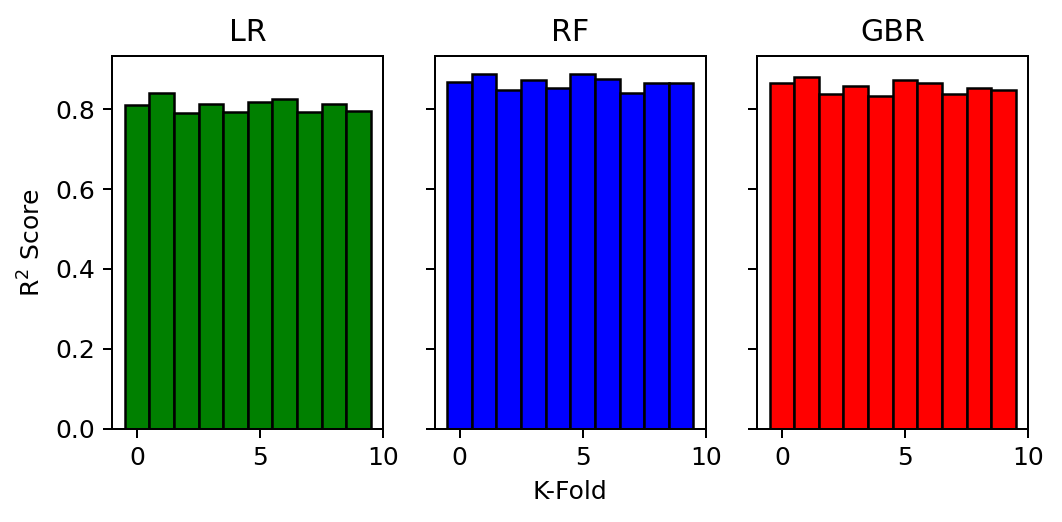

In [27]:
plt.rcParams['font.size'] = 10
xlabel = []
for i in range(10) :
    xlabel.append("Fold %i"%(i+1))

fig, axes = plt.subplots(1,3,figsize=(6,3),dpi=180,sharey=True,sharex=True)
axes[0].set_title("LR")
axes[0].bar(range(10),data_dict['LR_log'],width=1,edgecolor='k',color='g')
axes[0].set_ylabel("R$^2$ Score")

axes[1].set_title("RF")
axes[1].bar(range(10),data_dict['RF_log'],width=1,edgecolor='k',color='b')
axes[1].set_xlabel("K-Fold")

axes[2].set_title("GBR")
axes[2].bar(range(10),data_dict['GBR_log'],width=1,edgecolor='k',color='r')
fig.tight_layout()

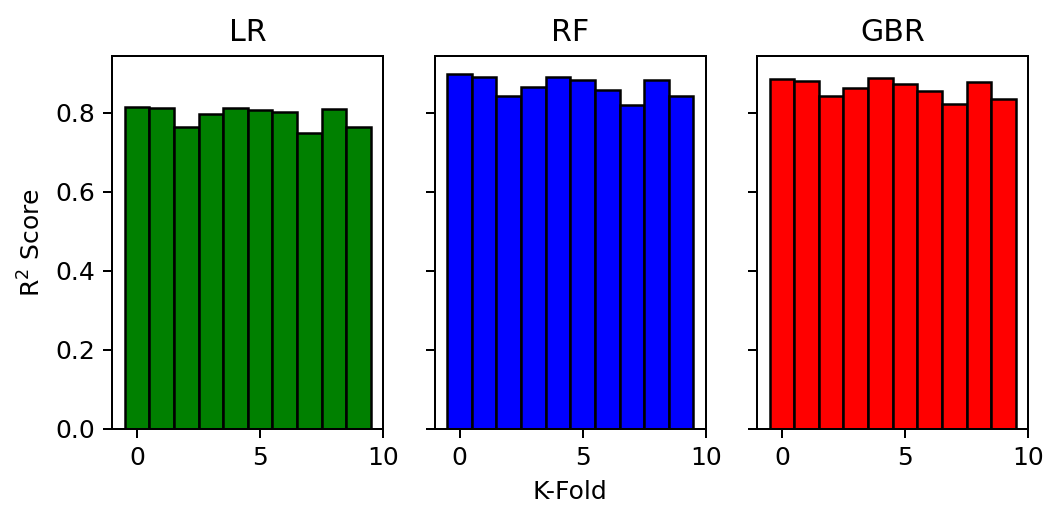

In [28]:
plt.rcParams['font.size'] = 10
xlabel = []
for i in range(10) :
    xlabel.append("Fold %i"%(i+1))

fig, axes = plt.subplots(1,3,figsize=(6,3),dpi=180,sharey=True,sharex=True)
axes[0].set_title("LR")
axes[0].bar(range(10),data_dict['LR'],width=1,edgecolor='k',color='g')
axes[0].set_ylabel("R$^2$ Score")

axes[1].set_title("RF")
axes[1].bar(range(10),data_dict['RF'],width=1,edgecolor='k',color='b')
axes[1].set_xlabel("K-Fold")

axes[2].set_title("GBR")
axes[2].bar(range(10),data_dict['GBR'],width=1,edgecolor='k',color='r')
fig.tight_layout()

#  5.  평가하기 (Validation)

## Linear Regression 

Log scale (log(GPa)): MAE : 0.087  MSE : 0.024 R2 : 0.807
Log scale (GPa): MAE : 14.561  MSE : 787.476 R2 : 0.805


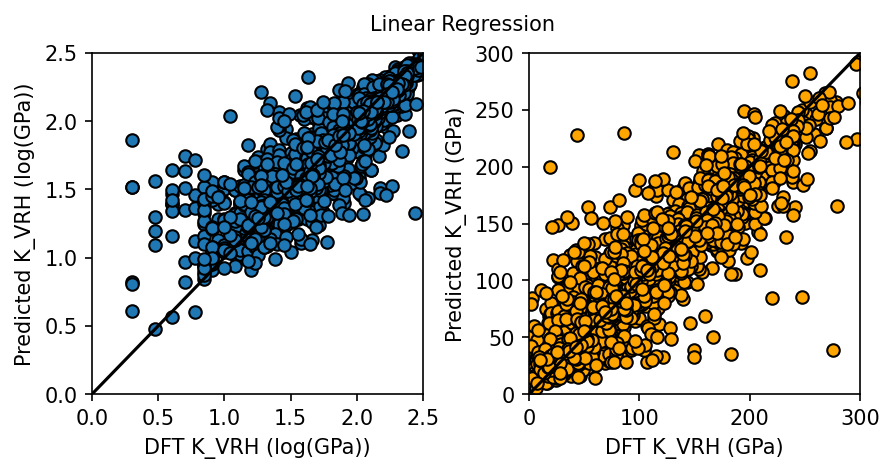

In [52]:
fig, axes = plt.subplots(1,2,figsize=(6,3),dpi=150)

predict_1 = log_lr_fit.predict(test_x)
predict_2 = lr_fit.predict(test_x)

axes[0].scatter(test_log_y,predict_1,edgecolor='k')
axes[1].scatter(test_y,predict_2,edgecolor='k',color='orange')

axes[0].set_xlabel("DFT K_VRH (log(GPa))")
axes[0].set_ylabel("Predicted K_VRH (log(GPa))")
axes[1].set_xlabel("DFT K_VRH (GPa)")
axes[1].set_ylabel("Predicted K_VRH (GPa)")

fig.text(0.42,1,"Linear Regression")
fig.tight_layout()

axes[0].plot([0,2.5],[0,2.5],'k-')
axes[1].plot([0,300],[0,300],'k-')

axes[0].set_xlim(0,2.5) ; axes[0].set_ylim(0,2.5)
axes[1].set_xlim(0,300) ; axes[1].set_ylim(0,300)

mae_log = mean_absolute_error(test_log_y,predict_1)
mse_log = mean_squared_error(test_log_y,predict_1)
r2_log = r2_score(test_log_y,predict_1)

mae = mean_absolute_error(test_y,predict_2)
mse = mean_squared_error(test_y,predict_2)
r2 = r2_score(test_y,predict_2)

print("Log scale (log(GPa)): MAE : %.3f  MSE : %.3f R2 : %.3f"%(mae_log, mse_log, r2_log))
print("Log scale (GPa): MAE : %.3f  MSE : %.3f R2 : %.3f"%(mae, mse, r2))

## Random Forest Regression 

Log scale (log(GPa)): MAE : 0.087  MSE : 0.024 R2 : 0.808
Log scale (GPa): MAE : 14.542  MSE : 784.056 R2 : 0.806


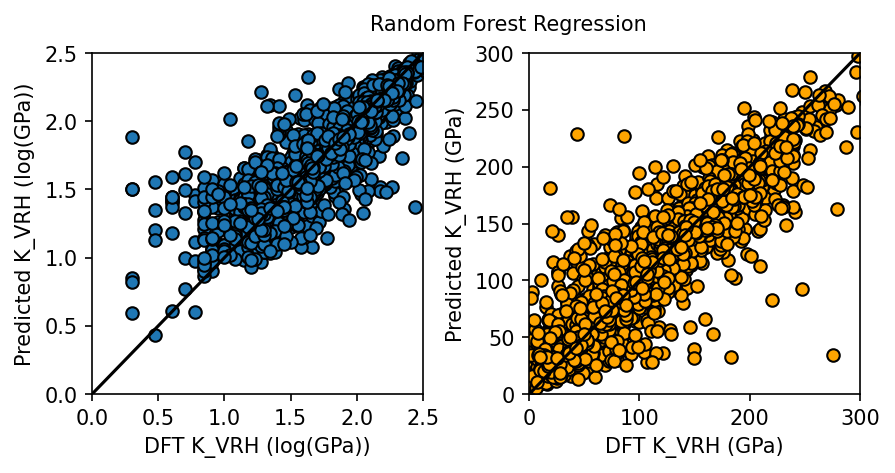

In [71]:
fig, axes = plt.subplots(1,2,figsize=(6,3),dpi=150)

predict_1 = log_rf_fit.predict(test_x)
predict_2 = rf_fit.predict(test_x)

axes[0].scatter(test_log_y,predict_1,edgecolor='k')
axes[1].scatter(test_y,predict_2,edgecolor='k',color='orange')

axes[0].set_xlabel("DFT K_VRH (log(GPa))")
axes[0].set_ylabel("Predicted K_VRH (log(GPa))")
axes[1].set_xlabel("DFT K_VRH (GPa)")
axes[1].set_ylabel("Predicted K_VRH (GPa)")

fig.text(0.42,1,"Random Forest Regression")
fig.tight_layout()

axes[0].plot([0,2.5],[0,2.5],'k-')
axes[1].plot([0,300],[0,300],'k-')

axes[0].set_xlim(0,2.5) ; axes[0].set_ylim(0,2.5)
axes[1].set_xlim(0,300) ; axes[1].set_ylim(0,300)

mae_log = mean_absolute_error(test_log_y,predict_1)
mse_log = mean_squared_error(test_log_y,predict_1)
r2_log = r2_score(test_log_y,predict_1)

mae = mean_absolute_error(test_y,predict_2)
mse = mean_squared_error(test_y,predict_2)
r2 = r2_score(test_y,predict_2)

print("Log scale (log(GPa)): MAE : %.3f  MSE : %.3f R2 : %.3f"%(mae_log, mse_log, r2_log))
print("Log scale (GPa): MAE : %.3f  MSE : %.3f R2 : %.3f"%(mae, mse, r2))

C:\Users\sora_\AppData\Local\Temp\ipykernel_6280\146277438.py:20: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


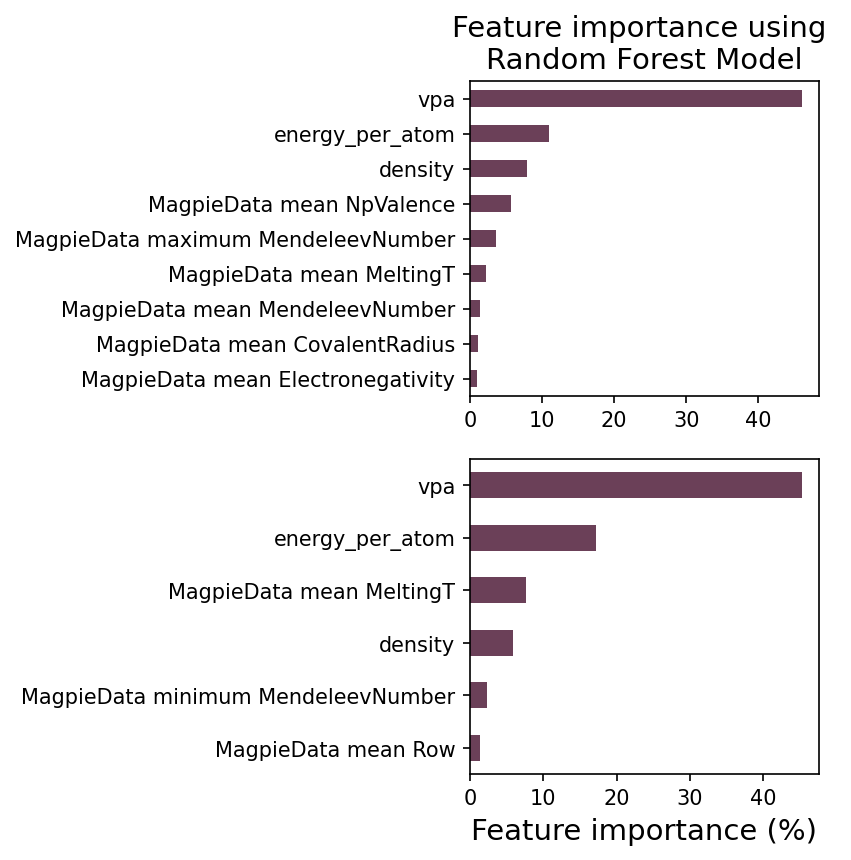

In [74]:
fig, axes = plt.subplots(2,1,figsize=(3,6),dpi=150)

coef = rf1.feature_importances_
coef_ser = pd.Series(rf1.feature_importances_, index = features.columns)

imp_coef = coef_ser.sort_values()
imp_coef_002 = imp_coef[imp_coef>0.01]*100
imp_coef_002.plot(kind = "barh",color='#6B4058',ax=axes[0])

coef = rf2.feature_importances_
coef_ser = pd.Series(rf2.feature_importances_, index = features.columns)

imp_coef = coef_ser.sort_values()
imp_coef_002 = imp_coef[imp_coef>0.01]*100
imp_coef_002.plot(kind = "barh",color='#6B4058',ax=axes[1])

axes[0].set_title("Feature importance using \nRandom Forest Model", fontsize=14)
axes[1].set_xlabel("Feature importance (%)", fontsize=14)

fig.tight_layout()

# Gradient Boosting Regression

Log scale (log(GPa)): MAE : 0.092  MSE : 0.025 R2 : 0.801
Log scale (GPa): MAE : 15.217  MSE : 791.186 R2 : 0.804


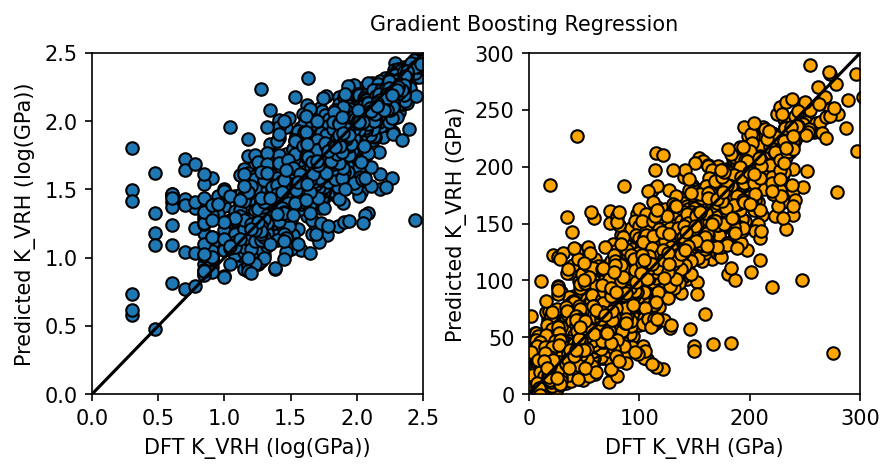

In [77]:
fig, axes = plt.subplots(1,2,figsize=(6,3),dpi=150)

predict_1 = log_gbr_fit.predict(test_x)
predict_2 = gbr_fit2.predict(test_x)

axes[0].scatter(test_log_y,predict_1,edgecolor='k')
axes[1].scatter(test_y,predict_2,edgecolor='k',color='orange')

axes[0].set_xlabel("DFT K_VRH (log(GPa))")
axes[0].set_ylabel("Predicted K_VRH (log(GPa))")
axes[1].set_xlabel("DFT K_VRH (GPa)")
axes[1].set_ylabel("Predicted K_VRH (GPa)")

fig.text(0.42,1,"Gradient Boosting Regression")
fig.tight_layout()

axes[0].plot([0,2.5],[0,2.5],'k-')
axes[1].plot([0,300],[0,300],'k-')

axes[0].set_xlim(0,2.5) ; axes[0].set_ylim(0,2.5)
axes[1].set_xlim(0,300) ; axes[1].set_ylim(0,300)

mae_log = mean_absolute_error(test_log_y,predict_1)
mse_log = mean_squared_error(test_log_y,predict_1)
r2_log = r2_score(test_log_y,predict_1)

mae = mean_absolute_error(test_y,predict_2)
mse = mean_squared_error(test_y,predict_2)
r2 = r2_score(test_y,predict_2)

print("Log scale (log(GPa)): MAE : %.3f  MSE : %.3f R2 : %.3f"%(mae_log, mse_log, r2_log))
print("Log scale (GPa): MAE : %.3f  MSE : %.3f R2 : %.3f"%(mae, mse, r2))

C:\Users\sora_\AppData\Local\Temp\ipykernel_6280\2343147987.py:20: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


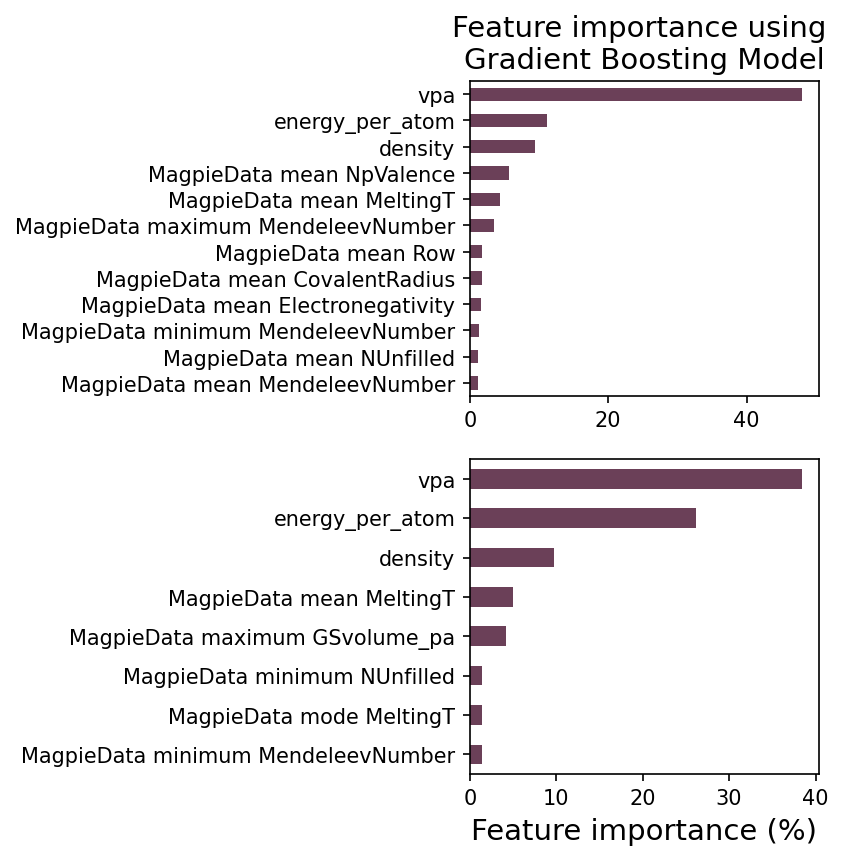

In [78]:
fig, axes = plt.subplots(2,1,figsize=(3,6),dpi=150)

coef = gbr1.feature_importances_
coef_ser = pd.Series(gbr1.feature_importances_, index = features.columns)

imp_coef = coef_ser.sort_values()
imp_coef_002 = imp_coef[imp_coef>0.01]*100
imp_coef_002.plot(kind = "barh",color='#6B4058',ax=axes[0])

coef = gbr2.feature_importances_
coef_ser = pd.Series(gbr2.feature_importances_, index = features.columns)

imp_coef = coef_ser.sort_values()
imp_coef_002 = imp_coef[imp_coef>0.01]*100
imp_coef_002.plot(kind = "barh",color='#6B4058',ax=axes[1])

axes[0].set_title("Feature importance using \nGradient Boosting Model", fontsize=14)
axes[1].set_xlabel("Feature importance (%)", fontsize=14)

fig.tight_layout()